In [1]:
import numpy as np
import matplotlib as mplt
import matplotlib.pyplot as plt
from tqdm import tqdm
from scipy.optimize import curve_fit
from scipy.integrate import cumulative_trapezoid
from scipy.interpolate import RegularGridInterpolator
import pandas as pd
import random
import math
import copy
from typing import Annotated, Any, Callable
from pydantic import BaseModel, Field, WithJsonSchema
import pydantic
import ipywidgets as widgets
import random
from typing import (
    Any, Callable, Optional, Sequence, Union, Tuple, Dict, List
)

In [20]:
%load_ext autoreload
%autoreload 2

import sys
for p in ['../src']:
    if p not in sys.path:
        sys.path.append(p)
        
import spikeml as sml
from spikeml.utils.nb_util import xdisplay, Markup
from spikeml.core.signal import signal_dc, signal_pulse, encode1_onehot, encode_onehot, signal_ranges, signal_unique, signal_ranges, signal_changes, mean_per_input
from spikeml.core.feedback import compute_error, xcompute_error, OutputAggregation, compute_sg

from spikeml.plot.plot_util import plot_hist, plot_data, plot_lidata, plot_input, plot_xt, plot_mt, plot_spikes, imshow_matrix, imshow_nmatrix

from spikeml.core.params import SSNNParams
from spikeml.core.spikes import pspike, spike
from spikeml.core.params import SSensorParams


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# compute_error

In [10]:
def test_compute_error(strict=False):
    params = SSNNParams()
    print(params.fmt())
    params = SSNNParams(g=1, e_err=5, pmax=1, e_z=2)
    print(params.fmt())
    data = {'sx': [], 'y': [], 'err': [], 'sg': [], 's': [], 'sm': [], 'ps': [], 'zs': []}
    def _err(s, y):
        err = compute_error(s, y, strict=strict)
        sg = compute_sg(err, params)
        s =  np.clip(sx + params.g*y, params.vmin, params.vmax).round(2)
        sm = np.clip(s*sg, params.vmin, params.vmax).round(2)
        ps = pspike(sm, params).round(2)
        zs = spike(sm, params)
        data['sx'].append(str(sx))
        data['y'].append(str(y))
        data['err'].append(err)
        data['sg'].append(sg)
        data['s'].append(str(s))
        data['sm'].append(str(sm))
        data['ps'].append(str(ps))
        data['zs'].append(str(zs))
        print(f'sx: {sx} y: {y}', f'-> err: {err:.2f}', f'; sg: {sg:.2f}', f'=> s: {s}', f'=> sm: {sm}', f'=> ps: {ps} ; zs: {zs}')
    for A in [.1, .3, .5]:
        sx = np.array([A,0.0])
        _err(sx, np.array([0.0,0.0]))
        _err(sx, sx)
        _err(sx, np.array([1.0,0]))
        _err(sx, np.array([0,1.0]))
        _err(sx, np.array([.5,0]))
        _err(sx, np.array([0,.5]))
        _err(sx, np.array([.5,.5]))

    df = pd.DataFrame(data)
    return df

df = test_compute_error()
display(df)


SSNNParams:c_k=2,t_c=10,t_p=1,t_d=5,c_in=0,c_out=0,cmin=-2,cmax=2,mean=0,sd=0.1,g=1,e_err=5,vmin=0,vmax=1,e_z=2,pf=1,pmax=1,t_b=20,e_b=2
SSNNParams:c_k=2,t_c=10,t_p=1,t_d=5,c_in=0,c_out=0,cmin=-2,cmax=2,mean=0,sd=0.1,g=1.0,e_err=5.0,vmin=0,vmax=1,e_z=2.0,pf=1,pmax=1.0,t_b=20,e_b=2
sx: [0.1 0. ] y: [0. 0.] -> err: 0.00 ; sg: 1.00 => s: [0.1 0. ] => sm: [0.1 0. ] => ps: [0.18 0.  ] ; zs: [0 0]
sx: [0.1 0. ] y: [0.1 0. ] -> err: 0.05 ; sg: 0.80 => s: [0.2 0. ] => sm: [0.16 0.  ] => ps: [0.27 0.  ] ; zs: [0 0]
sx: [0.1 0. ] y: [1. 0.] -> err: 0.45 ; sg: 0.11 => s: [1. 0.] => sm: [0.11 0.  ] => ps: [0.2 0. ] ; zs: [0 0]
sx: [0.1 0. ] y: [0. 1.] -> err: 0.50 ; sg: 0.08 => s: [0.1 1. ] => sm: [0.01 0.08] => ps: [0.02 0.15] ; zs: [0 0]
sx: [0.1 0. ] y: [0.5 0. ] -> err: 0.23 ; sg: 0.32 => s: [0.6 0. ] => sm: [0.19 0.  ] => ps: [0.32 0.  ] ; zs: [0 0]
sx: [0.1 0. ] y: [0.  0.5] -> err: 0.25 ; sg: 0.29 => s: [0.1 0.5] => sm: [0.03 0.14] => ps: [0.06 0.24] ; zs: [0 0]
sx: [0.1 0. ] y: [0.5 0.5] -

,sx,y,err,sg,s,sm,ps,zs
0,[0.1 0. ],[0. 0.],0.000,1.000000,[0.1 0. ],[0.1 0. ],[0.18 0. ],[0 0]
1,[0.1 0. ],[0.1 0. ],0.045,0.798516,[0.2 0. ],[0.16 0. ],[0.27 0. ],[0 0]
2,[0.1 0. ],[1. 0.],0.450,0.105399,[1. 0.],[0.11 0. ],[0.2 0. ],[0 0]
3,[0.1 0. ],[0. 1.],0.500,0.082085,[0.1 1. ],[0.01 0.08],[0.02 0.15],[0 0]
4,[0.1 0. ],[0.5 0. ],0.225,0.324652,[0.6 0. ],[0.19 0. ],[0.32 0. ],[0 0]
5,[0.1 0. ],[0. 0.5],0.250,0.286505,[0.1 0.5],[0.03 0.14],[0.06 0.24],[0 0]
6,[0.1 0. ],[0.5 0.5],0.475,0.093014,[0.6 0.5],[0.06 0.05],[0.11 0.1 ],[0 1]
7,[0.3 0. ],[0. 0.],0.000,1.000000,[0.3 0. ],[0.3 0. ],[0.45 0. ],[1 0]
8,[0.3 0. ],[0.3 0. ],0.105,0.591555,[0.6 0. ],[0.35 0. ],[0.5 0. ],[1 0]
9,[0.3 0. ],[1. 0.],0.350,0.173774,[1. 0.],[0.17 0. ],[0.29 0. ],[0 0]


In [16]:
def test_compute_error2(strict=False):
    params = SSNNParams()
    data = {'f': [], 'R': [], 'sx': [], 's':[], 'y': [], 'err': []}
    def _add(f, sx, s, y, R, err, debug=True):
        data['f'].append(f)
        data['sx'].append(sx)
        data['s'].append(s)
        data['y'].append(y)
        data['R'].append(R)
        data['err'].append(err)
        if debug:
            print(f'{f}: R: {R} ; s: {s} ; y: {y}', f'-> err: {err:.2f}')
        
    def _err(sx, y, R):
        s = np.repeat(sx, R)
        y1 = y.reshape(y.shape[0] // R, R).mean(axis=1)
        y2 = y.reshape(y.shape[0] // R, R).sum(axis=1)
        y2 =  np.clip(y2, params.vmin, params.vmax)
        y3 = y.reshape(y.shape[0] // R, R).max(axis=1)
        
        err = xcompute_error(sx, y, R=R, method=OutputAggregation.DP, strict=strict)
        err1 = xcompute_error(sx, y, R=R, method=OutputAggregation.MEAN, strict=strict)
        err2 = xcompute_error(sx, y, R=R, method=OutputAggregation.SUM_CLIP, strict=strict)
        err3 = xcompute_error(sx, y, R=R, method=OutputAggregation.MAX, strict=strict)
        print('-'*4)
        _add('dp', sx, s, y, R, err)
        _add('mean', sx, s, y1, R, err1)
        _add('sum+clip', sx, s, y2, R, err2)
        _add('max', sx, s, y3, R, err3)

               
    _err(np.array([1,0]), np.array([1,0]), R=1)
    _err(np.array([1,0]), np.array([1,1,0,0]), R=2)
    _err(np.array([1,0]), np.array([1,0,0,0]), R=2)
    _err(np.array([1,0]), np.array([0,1,0,0]), R=2)
    _err(np.array([1,0]), np.array([0,0,0,0]), R=2)
    _err(np.array([1,0]), np.array([0,0,1,1]), R=2)
    _err(np.array([1,0]), np.array([0,0,1,0]), R=2)
    _err(np.array([1,0]), np.array([0,0,0,1]), R=2)
    _err(np.array([1,0]), np.array([1,1,1,1]), R=2)
    _err(np.array([1,0]), np.array([0,0,0,1,1,1]), R=3)
    _err(np.array([1,0]), np.array([0,0,0,1,1,0]), R=3)
    _err(np.array([1,0]), np.array([0,0,0,0,1,0]), R=3)
    _err(np.array([1,0]), np.array([1,1,1,1,1,1]), R=3)
    
    df = pd.DataFrame(data)
    return df

df=test_compute_error2()
display(df)


----
dp: R: 1 ; s: [1 0] ; y: [1 0] -> err: 0.00
mean: R: 1 ; s: [1 0] ; y: [1. 0.] -> err: 0.00
sum+clip: R: 1 ; s: [1 0] ; y: [1 0] -> err: 0.00
max: R: 1 ; s: [1 0] ; y: [1 0] -> err: 0.00
----
dp: R: 2 ; s: [1 1 0 0] ; y: [1 1 0 0] -> err: 0.00
mean: R: 2 ; s: [1 1 0 0] ; y: [1. 0.] -> err: 0.00
sum+clip: R: 2 ; s: [1 1 0 0] ; y: [1 0] -> err: 0.00
max: R: 2 ; s: [1 1 0 0] ; y: [1 0] -> err: 0.00
----
dp: R: 2 ; s: [1 1 0 0] ; y: [1 0 0 0] -> err: 0.00
mean: R: 2 ; s: [1 1 0 0] ; y: [0.5 0. ] -> err: 0.00
sum+clip: R: 2 ; s: [1 1 0 0] ; y: [1 0] -> err: 0.00
max: R: 2 ; s: [1 1 0 0] ; y: [1 0] -> err: 0.00
----
dp: R: 2 ; s: [1 1 0 0] ; y: [0 1 0 0] -> err: 0.00
mean: R: 2 ; s: [1 1 0 0] ; y: [0.5 0. ] -> err: 0.00
sum+clip: R: 2 ; s: [1 1 0 0] ; y: [1 0] -> err: 0.00
max: R: 2 ; s: [1 1 0 0] ; y: [1 0] -> err: 0.00
----
dp: R: 2 ; s: [1 1 0 0] ; y: [0 0 0 0] -> err: 0.00
mean: R: 2 ; s: [1 1 0 0] ; y: [0. 0.] -> err: 0.00
sum+clip: R: 2 ; s: [1 1 0 0] ; y: [0 0] -> err: 0.00
max: 

,f,R,sx,s,y,err
0,dp,1,"[1, 0]","[1, 0]","[1, 0]",0.000000
1,mean,1,"[1, 0]","[1, 0]","[1.0, 0.0]",0.000000
2,sum+clip,1,"[1, 0]","[1, 0]","[1, 0]",0.000000
3,max,1,"[1, 0]","[1, 0]","[1, 0]",0.000000
4,dp,2,"[1, 0]","[1, 1, 0, 0]","[1, 1, 0, 0]",0.000000
5,mean,2,"[1, 0]","[1, 1, 0, 0]","[1.0, 0.0]",0.000000
6,sum+clip,2,"[1, 0]","[1, 1, 0, 0]","[1, 0]",0.000000
7,max,2,"[1, 0]","[1, 1, 0, 0]","[1, 0]",0.000000
8,dp,2,"[1, 0]","[1, 1, 0, 0]","[1, 0, 0, 0]",0.000000
9,mean,2,"[1, 0]","[1, 1, 0, 0]","[0.5, 0.0]",0.000000


SSensorParams:g=1,e_err=1.0,vmin=0,vmax=1,e_z=2,pf=1,pmax=1,upsample_method=UpsampleMethod.REPEAT


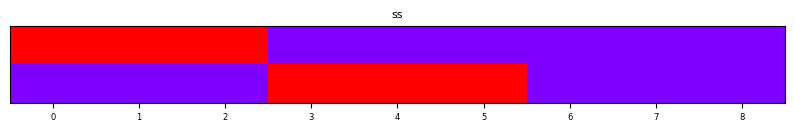

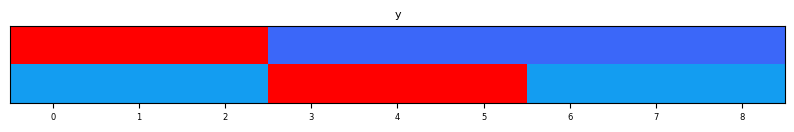

err: [[0.         0.21162878]
 [0.         0.21162878]
 [0.         0.21162878]
 [0.13405476 0.        ]
 [0.13405476 0.        ]
 [0.13405476 0.        ]
 [0.13405476 0.21162878]
 [0.13405476 0.21162878]
 [0.13405476 0.21162878]]
sg: [[1.         0.80926506]
 [1.         0.80926506]
 [1.         0.80926506]
 [0.87454217 1.        ]
 [0.87454217 1.        ]
 [0.87454217 1.        ]
 [0.87454217 0.80926506]
 [0.87454217 0.80926506]
 [0.87454217 0.80926506]]
0.21162877763024712


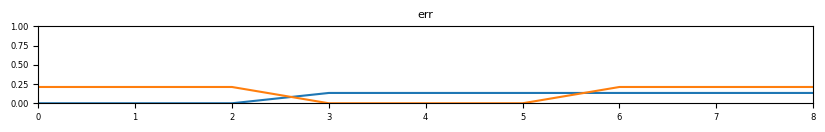

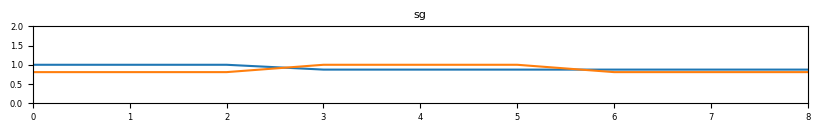

err: [0.10581439 0.10581439 0.10581439 0.06702738 0.06702738 0.06702738
 0.17284177 0.17284177 0.17284177]
sg: [0.89959161 0.89959161 0.89959161 0.9351696  0.9351696  0.9351696
 0.84127072 0.84127072 0.84127072]
1
0 2


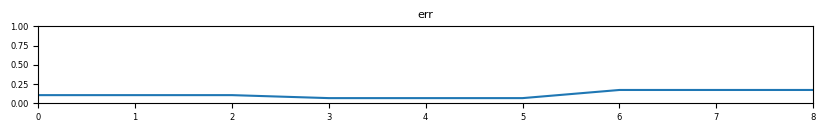

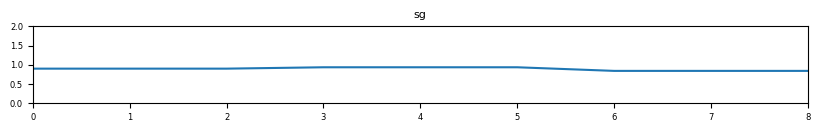

In [53]:

def test_compute_error_N(scale=1):
    params = SSensorParams(e_err=1)
    print(params.fmt())
    ss = signal_pulse(2, T=3, L=1, s=[0,1,-1], value=1)
    r = np.random.normal(loc=0, scale=scale, size=ss.shape[-1])
    y = np.clip(ss + r, params.vmin, params.vmax)
    plot_xt(ss, title='ss')
    plot_xt(y, title='y')
    err = compute_error(ss, y, mean=False)
    sg = compute_sg(err, params)
    print('err:', err)
    print('sg:', sg)
    #plot_data(err, title=f'err', callback=lambda ax: plot_input(ss,ax=ax), ylim=(0,ymax))
    #plot_data(sg, title=f'sg', callback=lambda ax: plot_input(ss,ax=ax), ylim=(0,ymax))
    print(err.max())
    plot_data(err, title=f'err', ylim=(0,max(.1, round(err.max()+1))))
    plot_data(sg, title=f'sg', ylim=(0,round(sg.max()+1)))

    err = compute_error(ss, y, mean=True)
    sg = compute_sg(err, params)
    print('err:', err)
    print('sg:', sg)
    #plot_data(err, title=f'err', callback=lambda ax: plot_input(ss,ax=ax), ylim=(0,max(.1, err.max())))
    #plot_data(sg, title=f'sg', callback=lambda ax: plot_input(ss,ax=ax), ylim=(0,max(.1, sg.max())))
    print(max(.1, round(err.max()+1)))
    print(0,round(sg.max()+1))
    plot_data(err, title=f'err', ylim=(0,max(.1, round(err.max()+1))))
    plot_data(sg, title=f'sg', ylim=(0,round(sg.max()+1)))


test_compute_error_N(scale=.5)


SSensorParams:g=1,e_err=1.0,vmin=0,vmax=1,e_z=2,pf=1,pmax=1,upsample_method=UpsampleMethod.REPEAT


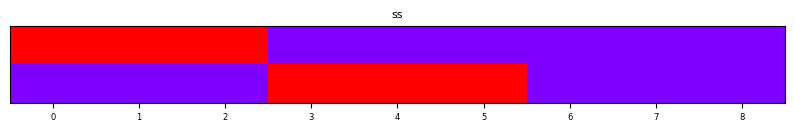

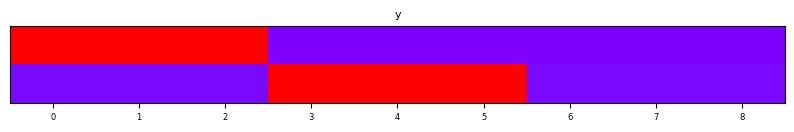

err: [[0.         0.01233653]
 [0.         0.01233653]
 [0.         0.01233653]
 [0.         0.        ]
 [0.         0.        ]
 [0.         0.        ]
 [0.         0.01233653]
 [0.         0.01233653]
 [0.         0.01233653]]
sg: [[1.         0.98773925]
 [1.         0.98773925]
 [1.         0.98773925]
 [1.         1.        ]
 [1.         1.        ]
 [1.         1.        ]
 [1.         0.98773925]
 [1.         0.98773925]
 [1.         0.98773925]]
0.012336529538680136


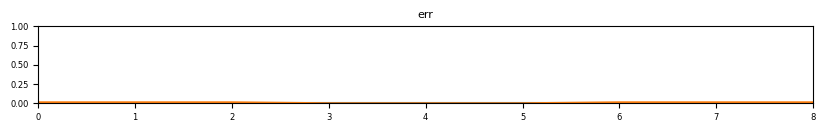

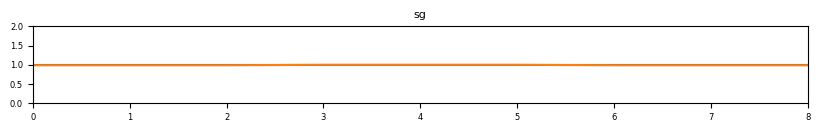

err: [0.00616826 0.00616826 0.00616826 0.         0.         0.
 0.00616826 0.00616826 0.00616826]
sg: [0.99385072 0.99385072 0.99385072 1.         1.         1.
 0.99385072 0.99385072 0.99385072]
1
0 2


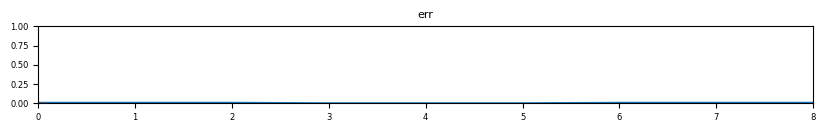

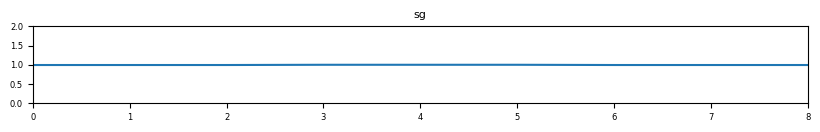

In [54]:
test_compute_error_N(scale=0.1)


SSensorParams:g=1,e_err=1.0,vmin=0,vmax=1,e_z=2,pf=1,pmax=1,upsample_method=UpsampleMethod.REPEAT


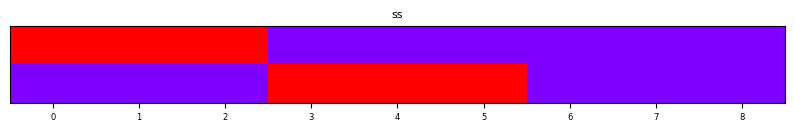

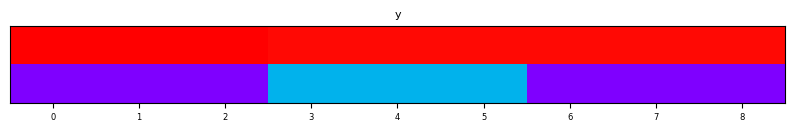

err: [[0.         0.        ]
 [0.         0.        ]
 [0.         0.        ]
 [0.98637213 0.        ]
 [0.98637213 0.        ]
 [0.98637213 0.        ]
 [0.98637213 0.        ]
 [0.98637213 0.        ]
 [0.98637213 0.        ]]
sg: [[1.         1.        ]
 [1.         1.        ]
 [1.         1.        ]
 [0.37292717 1.        ]
 [0.37292717 1.        ]
 [0.37292717 1.        ]
 [0.37292717 1.        ]
 [0.37292717 1.        ]
 [0.37292717 1.        ]]
0.9863721312427892


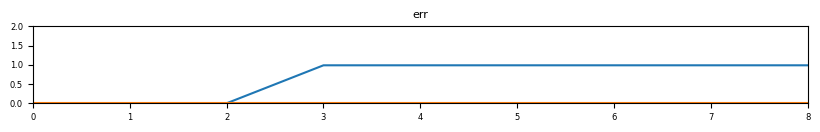

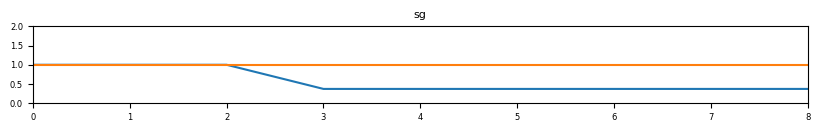

err: [0.         0.         0.         0.49318607 0.49318607 0.49318607
 0.49318607 0.49318607 0.49318607]
sg: [1.         1.         1.         0.61067763 0.61067763 0.61067763
 0.61067763 0.61067763 0.61067763]
1
0 2


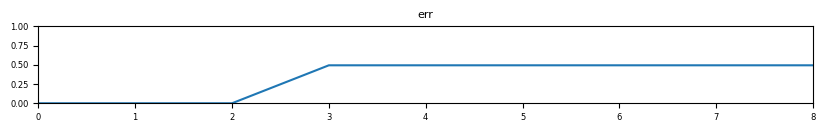

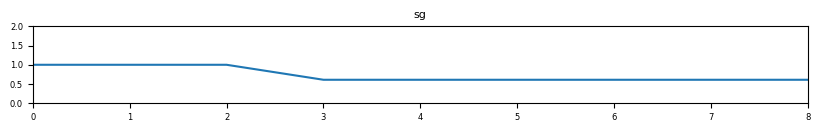

In [55]:
test_compute_error_N(scale=1)